<a href="https://colab.research.google.com/github/hmerkle/iannwtf_homework_group14/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time
import urllib
from IPython import display

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, Conv2DTranspose, Reshape, Activation, BatchNormalization, GlobalAvgPool2D

# Data pipeline

In [2]:
def prepare(data, batch_size):
  # reshape 1x784 pixel vectors to (28, 28, 1)
  data = data.map(lambda img: tf.reshape(img, (28, 28, 1)))
  
  #convert data from uint8 to float32
  data = data.map(lambda img : tf.cast(img, tf.float32))
    
  #input normalization, bringing image values from range [0, 255] to [-1, 1] -> (img/128.)-1.
  data = data.map(lambda img: (img/128.)-1.)

  #shuffle, batch, prefetch
  data = data.shuffle(1000)
  data = data.batch(batch_size)
  data = data.prefetch(500)

  #return preprocessed dataset
  return data

# Implementation of a GAN

### Discriminator

In [3]:
class Discriminator(tf.keras.Model):

  def __init__(self):
    super(Discriminator, self).__init__()
    # , kernel_regularizer = tf.keras.regularizers.L2(0.001)
    self.conv_1 = Conv2D(filters = 32, kernel_size = (3, 3), strides = 2, padding = 'same', activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), input_shape=(28, 28, 1))
    self.maxpool_1 = MaxPooling2D((2, 2), padding='same')
    self.dropout_1 = Dropout(0.1)

    self.conv_2 = Conv2D(filters = 64, kernel_size = (3, 3), strides = 2, padding = 'same', kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu')
    self.maxpool_2 = MaxPooling2D((2, 2), padding='same')
    self.dropout_2 = Dropout(0.1)

    self.conv_3 = Conv2D(filters = 128, kernel_size = (3, 3), strides = 2, padding = 'same', kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu')
    self.glob_pool = GlobalAvgPool2D()
    self.dense = Dense(1, activation="sigmoid")


  @tf.function
  def call(self, inputs, training):
    x = self.conv_1(inputs)
    x = self.maxpool_1(x)
    if training == True:
      x = self.dropout_1(x)
    x = self.conv_2(x)
    x = self.maxpool_2(x)
    if training == True:
      x = self.dropout_2(x)
    x = self.conv_3(x)
    x = self.glob_pool(x)
    x = self.dense(x)
    return x
    

### Generator

In [4]:
class Generator(tf.keras.Model):

  def __init__(self):
    super(Generator, self).__init__()
    # , kernel_regularizer = tf.keras.regularizers.L2(0.001)

    self.dense_1 = Dense(7*7*128, input_shape = (100,))
    #self.batch_norm_1 = BatchNormalization()
    self.act_1 = Activation("relu")

    self.reshape_1 = Reshape((7, 7, 128))

    self.conv_t_1 = Conv2DTranspose(64, kernel_size = (4, 4), strides = 1, padding = 'same')
    #self.batch_norm_2 = BatchNormalization()
    self.act_2 = Activation("relu")

    self.conv_t_2 = Conv2DTranspose(32, kernel_size = (4, 4), strides = 2, padding = 'same')
    #self.batch_norm_3 = BatchNormalization()
    self.act_3 = Activation("relu")

    self.conv_t_3 = Conv2DTranspose(1, kernel_size = (4, 4), strides = 2, padding = 'same', activation='tanh')
 

  @tf.function
  def call(self, inputs):
    x = self.dense_1(inputs)
    #x = self.batch_norm_1(x)
    x = self.act_1(x)

    x = self.reshape_1(x)

    x = self.conv_t_1(x)
    #x = self.batch_norm_2(x)
    x = self.act_2(x)

    x = self.conv_t_2(x)
    #x = self.batch_norm_3(x)
    x = self.act_3(x)

    x = self.conv_t_3(x)
    return x

# Training

In [5]:
# creating images with generator
def create_img(generator, batch_size):
  noise = tf.random.normal([batch_size, 100])
  generated_image = generator(noise)

  #plt.imshow(generated_image[0, :, :, 0], cmap='gray')
  return generated_image

In [6]:
# loss of  discriminator is based on how well the discriminator detected fake images as fake and real images as real
def get_discriminator_loss(bce_loss, real_prediction, fake_prediction):

    # compute BCE between  generators output on fake images and all labels=0
    fake_loss = bce_loss(fake_prediction, tf.zeros_like(fake_prediction))
    # compute BCE between generators output on the real images and all labels = 1
    real_loss = bce_loss(real_prediction, tf.ones_like(real_prediction))
    #Add them both to receive the resulting loss of the discriminator
    total_loss = real_loss + fake_loss
    
    return total_loss

In [7]:
# loss of generator is estimated by how well the generator was able to fool the discriminator
def get_generator_loss(bce_loss, fake_prediction):
    return bce_loss(fake_prediction, tf.ones_like(fake_prediction))

### *Train step*

In [8]:
def train_step(generator, discriminator, true_images, bce_loss, discriminator_optimizer, generator_optimizer, batch_size):
   
  # discriminator sees a batch of true images and a batch of the generated
  with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:

    # each training step generator is fed with random noise and creates images from it
    generated_images = create_img(generator, batch_size) 

    real_prediction = discriminator(true_images, True)
    fake_prediction = discriminator(generated_images, True)

    # calculate losses
    discriminator_loss = get_discriminator_loss(bce_loss, real_prediction, fake_prediction)
    generator_loss = get_generator_loss(bce_loss, fake_prediction)


  discriminator_gradients = d_tape.gradient(discriminator_loss, discriminator.trainable_variables)
  generator_gradients = g_tape.gradient(generator_loss, generator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  
  return discriminator_loss, generator_loss

### *Test step*

In [9]:
def test(generator, discriminator, true_images, bce_loss, batch_size):
  d_loss_aggregator = []
  g_loss_aggregator = []

  for image_batch in true_images:
    generated_images = create_img(generator, batch_size)

    real_prediction = discriminator(image_batch, False)
    fake_prediction = discriminator(generated_images, False)

    # calculate losses
    discriminator_loss = get_discriminator_loss(bce_loss, real_prediction, fake_prediction)
    generator_loss = get_generator_loss(bce_loss, fake_prediction)
    
    d_loss_aggregator.append(discriminator_loss.numpy())
    g_loss_aggregator.append(generator_loss.numpy())

  test_d_loss = tf.reduce_mean(d_loss_aggregator)
  test_g_loss = tf.reduce_mean(g_loss_aggregator)

  return test_d_loss, test_g_loss, generated_images

### Visualization

In [10]:
# Description: This function visualizes the losses of training and testing
def visualization(train_d_losses, train_g_losses, test_d_losses, test_g_losses):
  # Visualization of losses
  plt.figure()
  line1, = plt.plot(train_d_losses)
  line2, = plt.plot(test_d_losses)
  line3, = plt.plot(train_g_losses)
  line4, = plt.plot(test_g_losses)
  plt.title("Training and testing losses")
  plt.xlabel("Training steps")
  plt.ylabel("loss")
  plt.legend((line1, line2, line3, line4), ("Training Discriminator", "Testing Discriminator", "Training Generator", "Testing Generator"), fontsize=12)
  plt.show()

In [11]:
# Utility function to plot images
def plot_imgs(original, n, title):

  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(original[i]))
    plt.title(title)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
  plt.show()

# Execution

### Quickdraw get data

In [12]:
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
category = 'candle'

# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:10000]
# You should also define a samller subset of the images for testing..
test_images = images[10000:]

141545 images to train on


### Prepare data

In [13]:
batch_size = 32

# Creates tensorflow datasets for the training and test data.
train_ds = tf.data.Dataset.from_tensor_slices(train_images)
test_ds = tf.data.Dataset.from_tensor_slices(test_images)

train_ds = prepare(train_ds, batch_size)
test_ds = prepare(test_ds, batch_size)

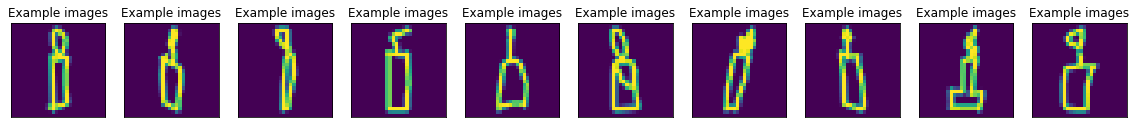

In [14]:
# show examples of pictures
for i in train_ds:
  plot_imgs(i, 10, "Example images")
  break

### Parameters

In [15]:
tf.keras.backend.clear_session()
### Hyperparameters
num_epochs = 10
learning_rate = 0.0001
    
# Initialize the optimizers: RMSprop
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate)
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate)

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Initialize the loss
bce_loss = tf.keras.losses.BinaryCrossentropy()

### Training

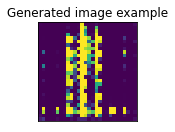

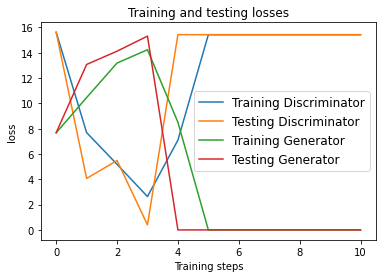

In [16]:
# Initialize lists for later visualization.
train_g_losses = []
test_g_losses = []

train_d_losses = []
test_d_losses = []


#testing once before we begin
d_test_loss, g_test_loss, _ = test(generator, discriminator, test_ds, bce_loss, batch_size)
test_d_losses.append(d_test_loss)
test_g_losses.append(g_test_loss)

#check how model performs on train data once before we begin
d_train_loss, g_train_loss, _ = test(generator, discriminator, train_ds, bce_loss, batch_size)
train_d_losses.append(d_train_loss)
train_g_losses.append(g_train_loss)

# We train for num_epochs epochs
for epoch in range(num_epochs):

    #training (and checking in with training)
    epoch_loss_agg_d = []
    epoch_loss_agg_g = []

    for image_batch in train_ds:
        d_train_loss, g_train_loss = train_step(generator, discriminator, image_batch, bce_loss, discriminator_optimizer, generator_optimizer, batch_size)
        epoch_loss_agg_d.append(d_train_loss)
        epoch_loss_agg_g.append(g_train_loss)

    #track training loss
    train_d_losses.append(tf.reduce_mean(epoch_loss_agg_d))
    train_g_losses.append(tf.reduce_mean(epoch_loss_agg_g))
    
    #testing, so we can track test loss
    d_test_loss, g_test_loss, generated_img = test(generator, discriminator, test_ds, bce_loss, batch_size)
    test_d_losses.append(d_test_loss)
    test_g_losses.append(g_test_loss)
    
    if epoch+1 == num_epochs:
      # show examples of generated pictures
      plot_imgs(generated_img, 1, "Generated image example")
      print("\n")

visualization(train_d_losses, train_g_losses, test_d_losses, test_g_losses)